# CS 445 Final Project MS

In [1]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
import os

In [2]:
%matplotlib notebook

## Import Image

In [3]:
def normalizeLum(img):
    lab_img = cv2.cvtColor(img, cv2.COLOR_BGR2Lab)
    new_img = np.zeros_like(lab_img)
    lum = lab_img[:,:,0].copy()
    hist, bins = np.histogram(lum,256,[0,256])
    cdf = hist.cumsum()
    cdf_normalized = cdf * float(hist.max()) / cdf.max()
    cdf_m = np.ma.masked_equal(cdf,0)
    cdf_m = (cdf_m - cdf_m.min())*255/(cdf_m.max()-cdf_m.min())
    cdf = np.ma.filled(cdf_m,0).astype('uint8')
    new_lum = cdf[lum]
    new_img[:,:,0] = new_lum
    new_img[:,:,1] = lab_img[:,:,1]
    new_img[:,:,2] = lab_img[:,:,2]
    return cv2.cvtColor(new_img, cv2.COLOR_Lab2BGR)

(563, 1000, 3) (563000, 3) 0 255


<IPython.core.display.Javascript object>


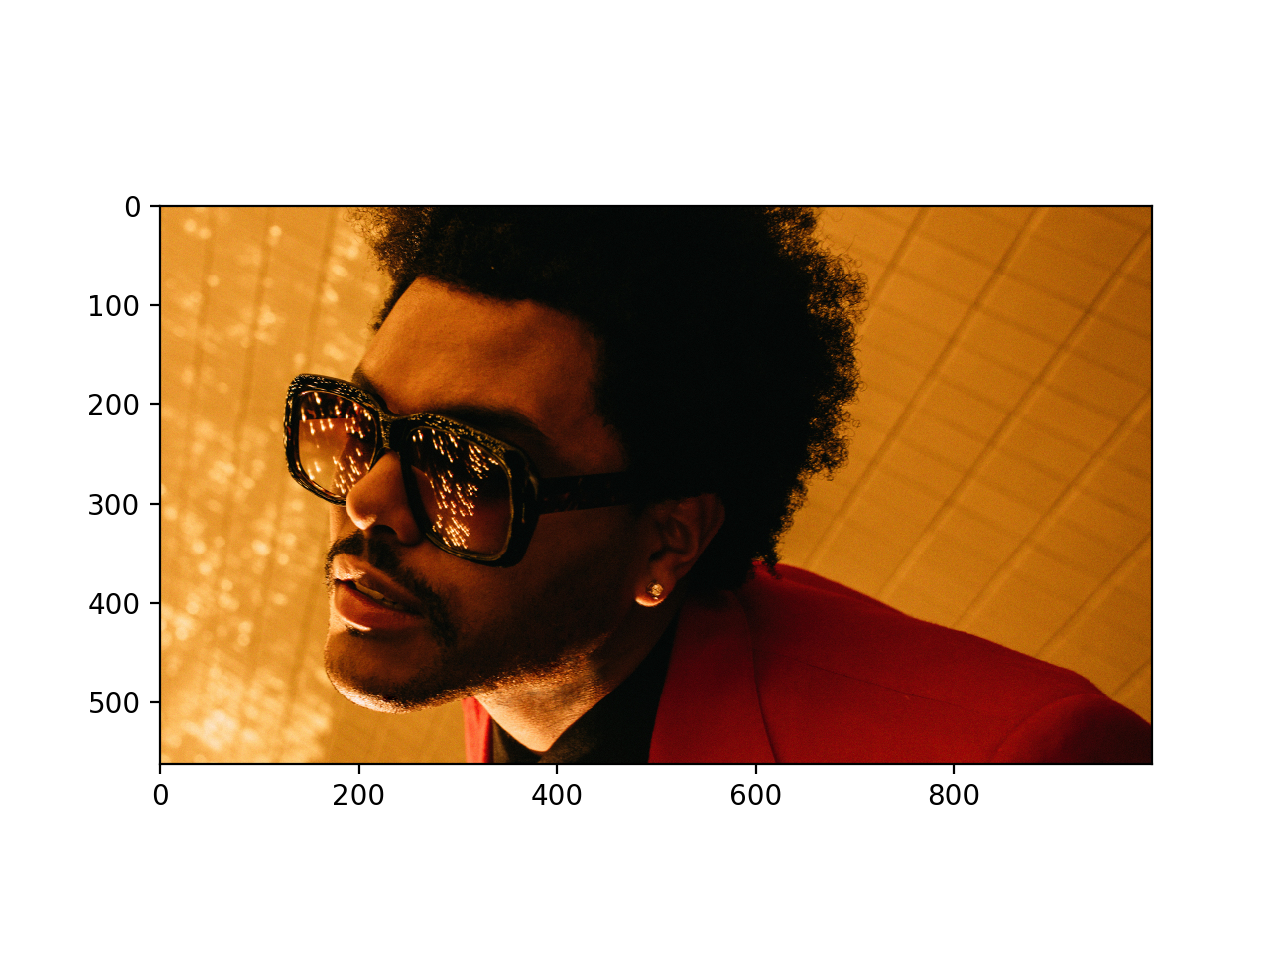

In [120]:
input_file_name = "./input/in6.jpg"
input_img = cv2.imread(input_file_name)
# input_img = cv2.cvtColor(input_img, cv2.COLOR_BGR2Lab)
# img_norm = normalizeLum(input_img)
img_flat = input_img.reshape(-1,3)
# lab_img_lum = cv2.cvtColor(input_img, cv2.COLOR_BGR2Lab)[:,:,0]
print(input_img.shape, img_flat.shape, img_flat.min(), img_flat.max())
plt.figure()
plt.imshow(cv2.cvtColor(input_img, cv2.COLOR_BGR2RGB))
plt.show()

## Functions

In [111]:
def euclid_distance(x, xi):
    return np.sqrt(np.sum((x - xi)**2))

def get_neighbors(Xs, X_cent, max_distance = 5):
    neighbors = []
    
    for X in Xs:
        dist = euclid_distance(X, X_cent)
        if dist <= max_distance:
            neighbors.append(X)
            
    return neighbors

def kernel(distance, bandwidth):
    """
    Compute gaussian pdf for distance using bandwidth.
    """
    pdf = (1/(bandwidth*np.sqrt(2*np.pi))) * np.exp(-0.5*((distance / bandwidth))**2)
    return pdf

In [112]:
def shift(Xs, maxIter=5, distance=5, bandwidth=25):
    """
    Calculate mean-shift operations until convergence (or until maxIter)
    Returns new Xs
    """
    pastXs = [Xs]
    currentXs = Xs.astype("float64")
    
    for iteration in range(maxIter):
        print("Iteration", iteration+1)
        newXs = np.zeros_like(currentXs)
        
        for i in range(len(currentXs)):
            if i%100==0:
                print("At pixel", i+1)
            X = currentXs[i]
#             nb_Xs = get_neighbors(currentXs, X, max_distance=distance)
#             if i%100==0:
#                 print("nb count =", len(nb_Xs))
            
            numerator = np.array([0,0,0], dtype="float64")
            denominator = np.array([0,0,0], dtype="float64")
            
            for nb_X in currentXs:
                dist = euclid_distance(X, nb_X)
                weight = kernel(dist, bandwidth)
                numerator += weight * nb_X
                denominator += weight
                
            newXs[i] = np.array(numerator/denominator, dtype="uint8")
        
        pastXs += [newXs]
        currentXs = newXs
    
    return currentXs, pastXs
        

In [116]:
shifted, pastXs = shift(img_flat, maxIter=5, distance=100, bandwidth=25)

Iteration 1
At pixel 1
At pixel 101
At pixel 201
At pixel 301
At pixel 401
At pixel 501
At pixel 601
At pixel 701
At pixel 801
At pixel 901
At pixel 1001
Iteration 2
At pixel 1
At pixel 101
At pixel 201
At pixel 301
At pixel 401
At pixel 501
At pixel 601
At pixel 701
At pixel 801
At pixel 901
At pixel 1001
Iteration 3
At pixel 1
At pixel 101
At pixel 201
At pixel 301
At pixel 401
At pixel 501
At pixel 601
At pixel 701
At pixel 801
At pixel 901
At pixel 1001
Iteration 4
At pixel 1
At pixel 101
At pixel 201
At pixel 301
At pixel 401
At pixel 501
At pixel 601
At pixel 701
At pixel 801
At pixel 901
At pixel 1001
Iteration 5
At pixel 1
At pixel 101
At pixel 201
At pixel 301
At pixel 401
At pixel 501
At pixel 601
At pixel 701
At pixel 801
At pixel 901
At pixel 1001


In [ ]:
print(shifted.min(), shifted.max())

<IPython.core.display.Javascript object>


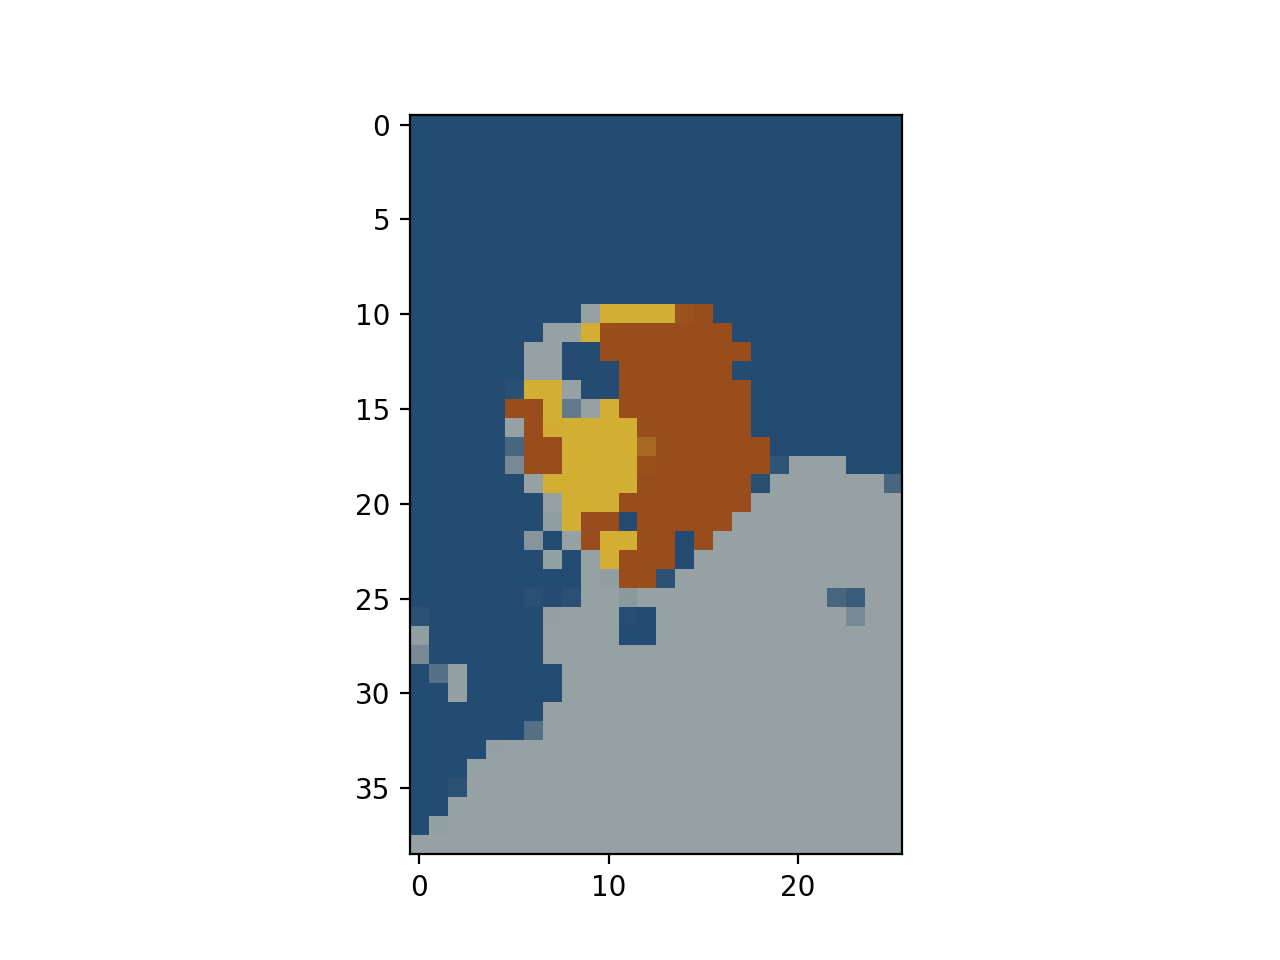

In [117]:
img_shifted = shifted.reshape(input_img.shape).astype("uint8")
# print(img_shifted==input_img)
plt.figure()
plt.imshow(cv2.cvtColor(img_shifted, cv2.COLOR_BGR2RGB))
plt.show()

<IPython.core.display.Javascript object>


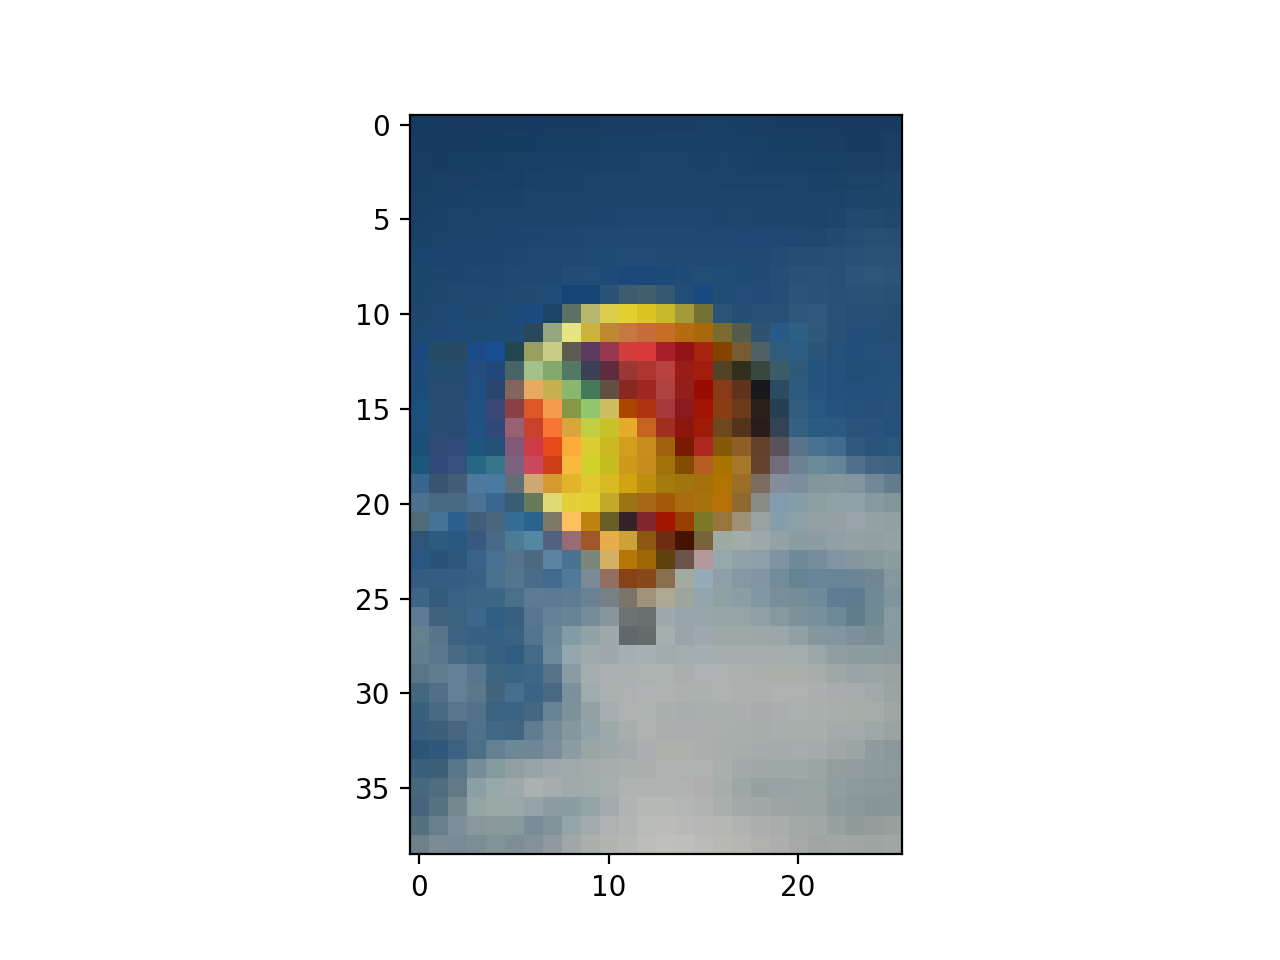

<IPython.core.display.Javascript object>


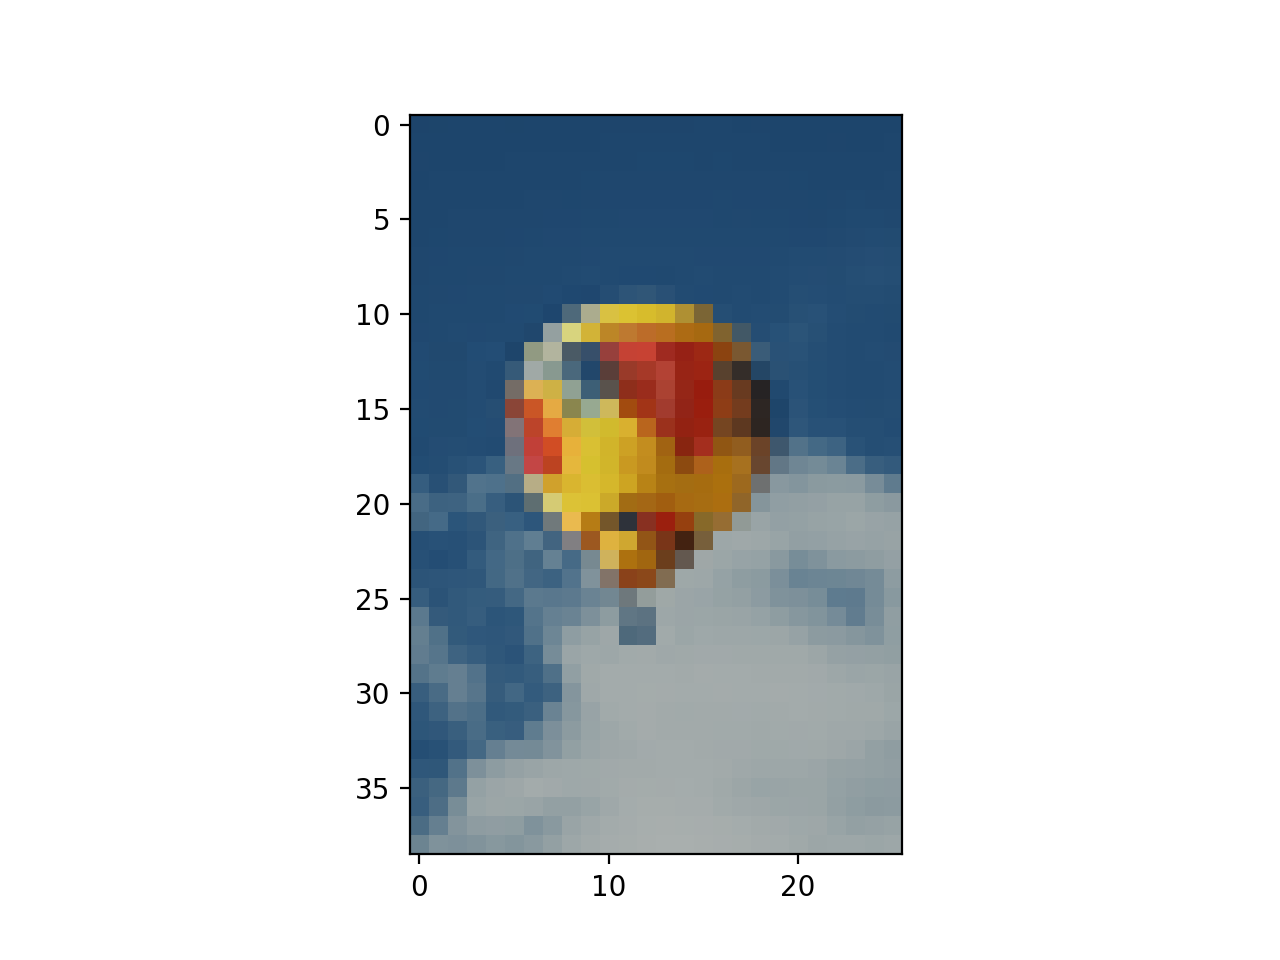

<IPython.core.display.Javascript object>


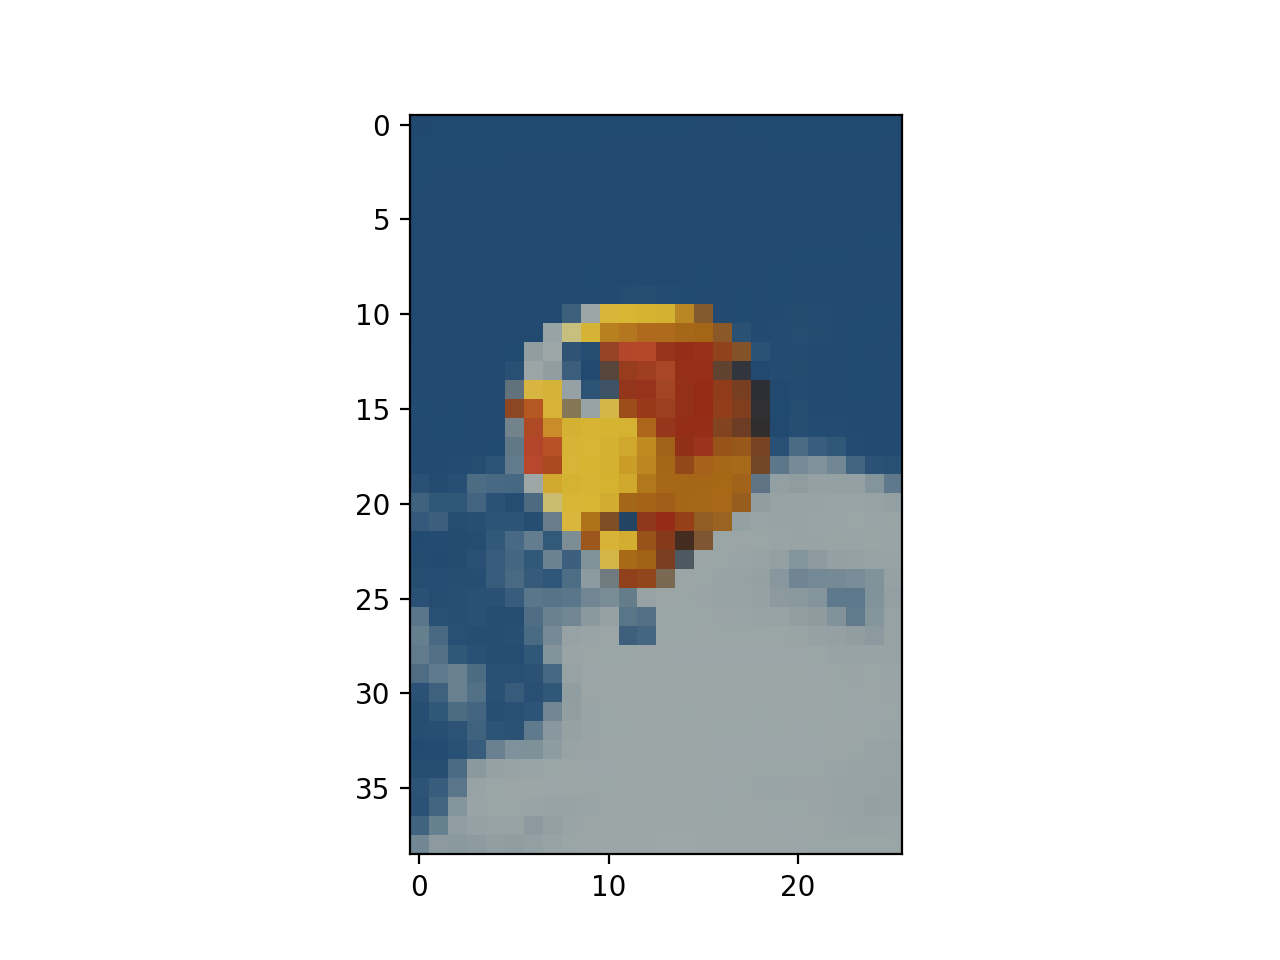

<IPython.core.display.Javascript object>


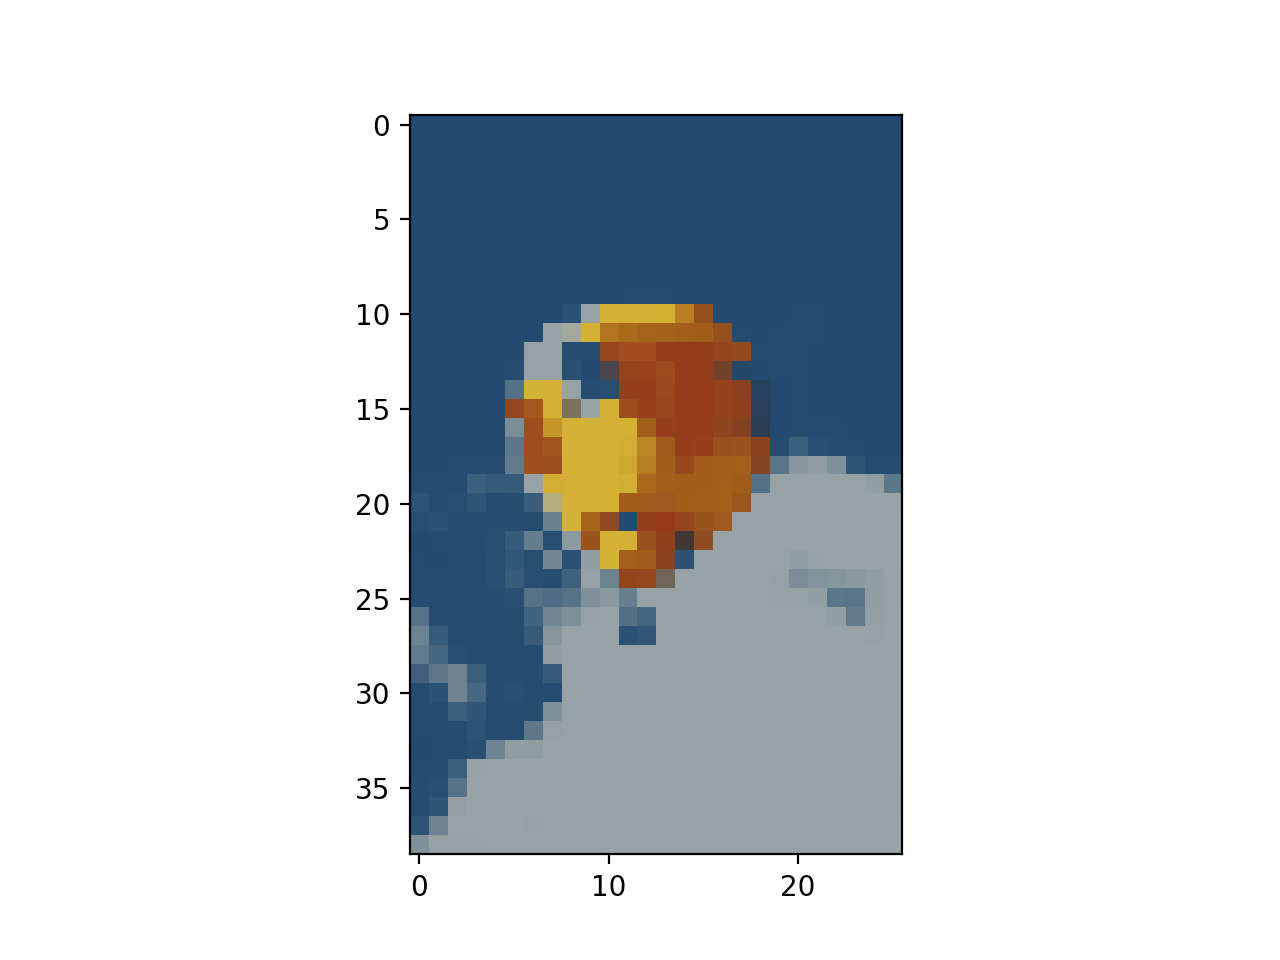

<IPython.core.display.Javascript object>


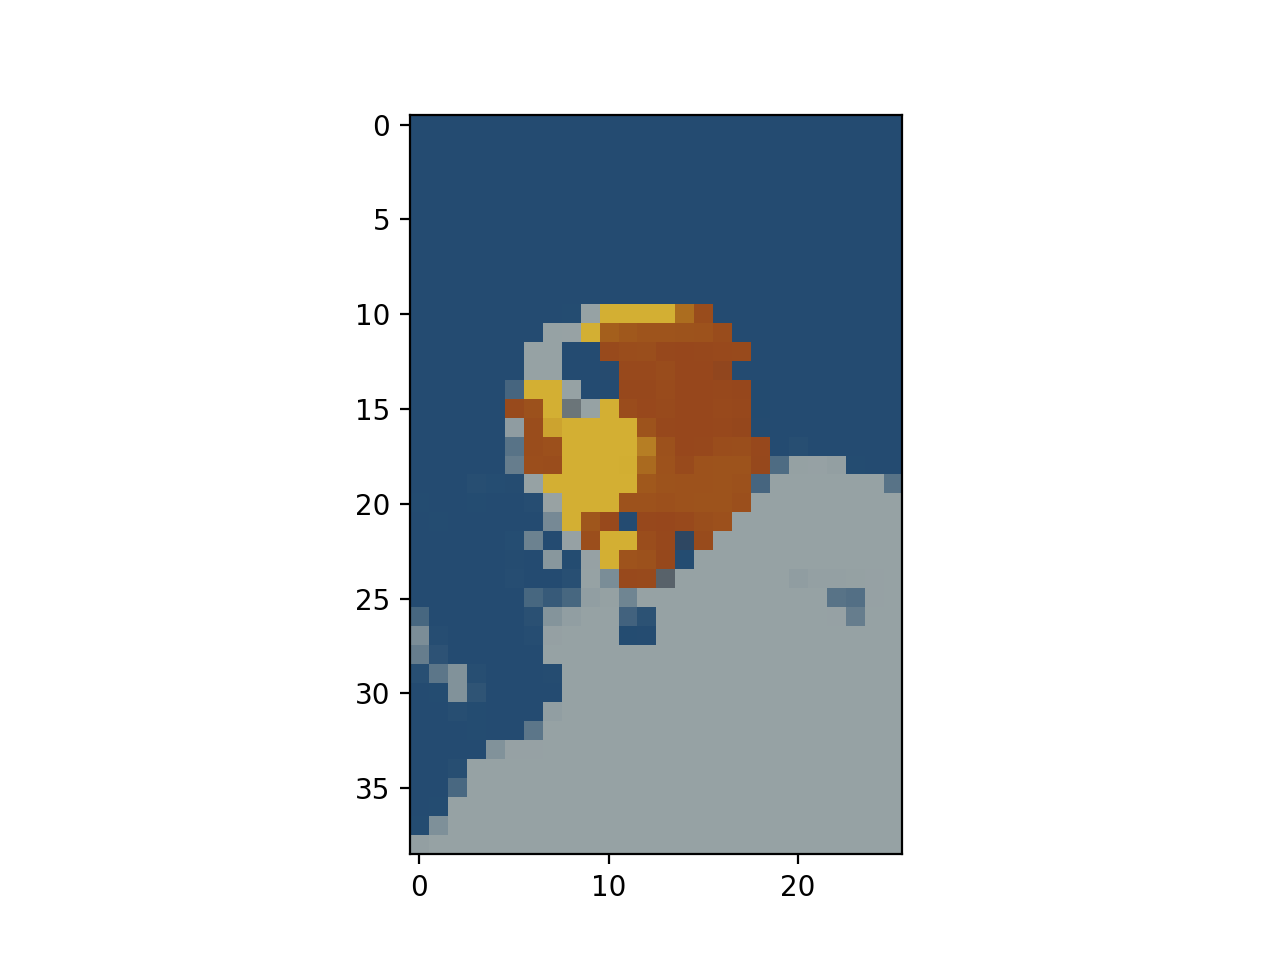

<IPython.core.display.Javascript object>


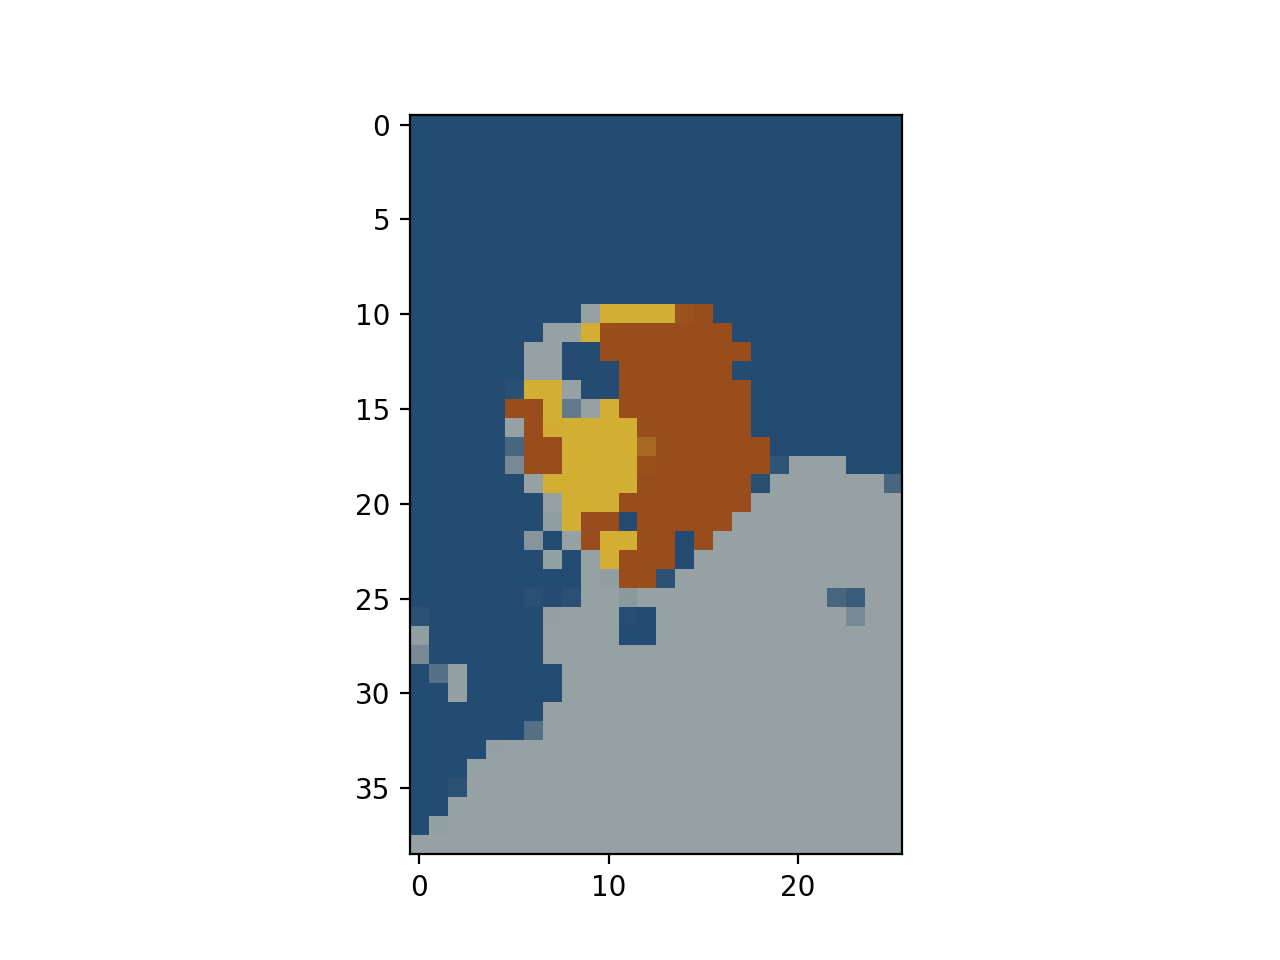

In [119]:
for i, pastX in enumerate(pastXs):
    img_shifted = pastX.reshape(input_img.shape).astype("uint8")
    plt.figure()
    plt.imshow(cv2.cvtColor(img_shifted, cv2.COLOR_BGR2RGB))
    plt.show()
    filename = "ms_{}.jpg".format(i)
    cv2.imwrite(filename, img_shifted);

## Using sklearn

In [5]:
from sklearn.cluster import MeanShift, estimate_bandwidth

In [121]:
bandwidth2 = estimate_bandwidth(img_flat, quantile=.2, n_samples=500)
ms = MeanShift(bandwidth2, bin_seeding=True)
ms.fit(img_flat)
labels = ms.labels_
labels = np.reshape(labels, input_img.shape[:2])

<IPython.core.display.Javascript object>


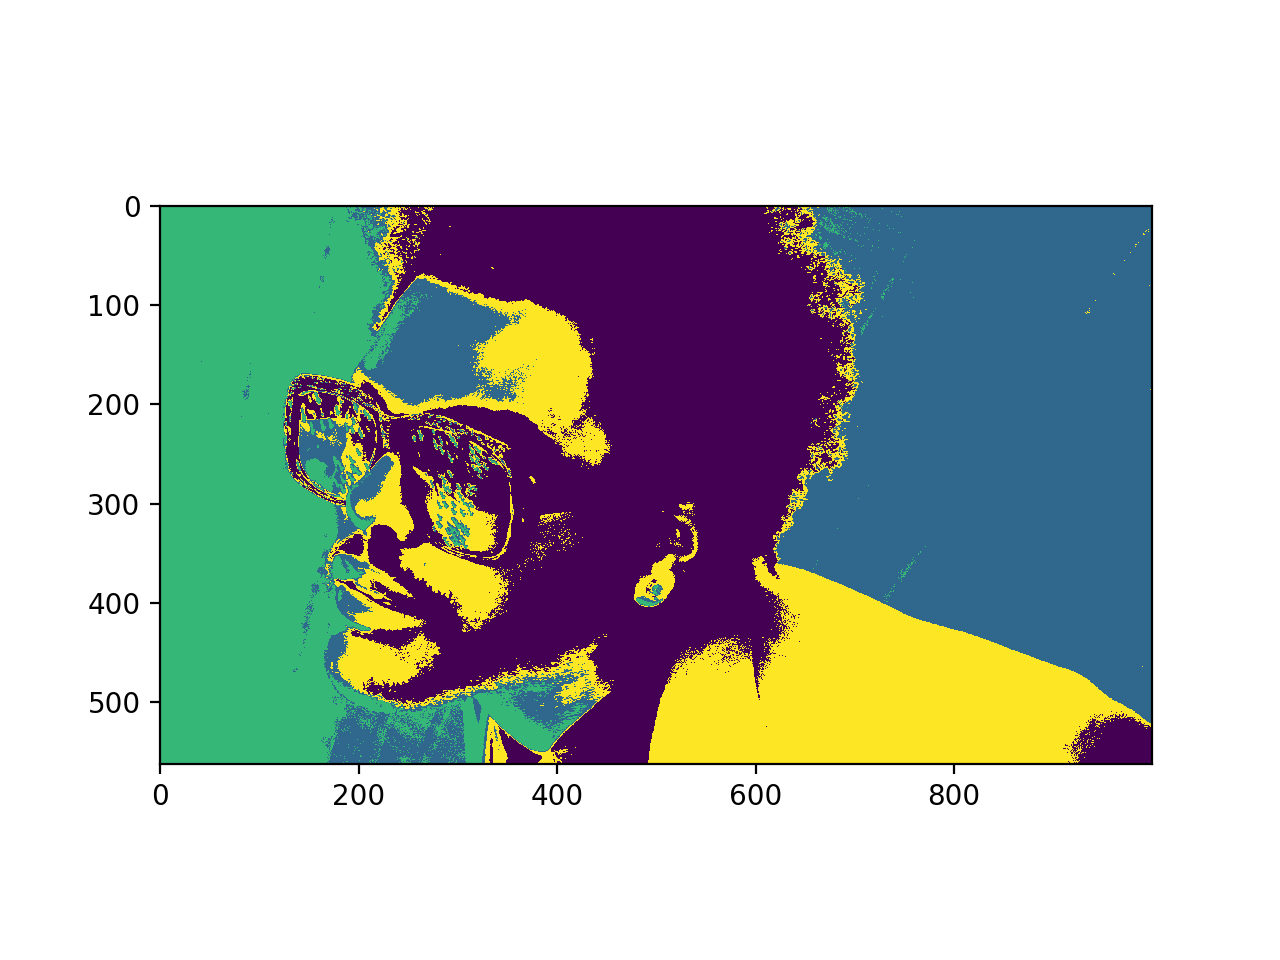

0 3


In [122]:
plt.figure()
plt.imshow(labels)
plt.show()
print(labels.min(), labels.max())

In [106]:
def label2Img(labels, img):
    newImg = np.zeros_like(img)
    N = labels.max()+1
    avgVal = np.zeros((N,3))
    count = np.zeros(N)
    H,W = img.shape[:2]
    for i in range(H):
        for j in range(W):
            l = labels[i,j]
            count[l] += 1
            avgVal[l] += img[i,j]
    
    avgVal = (avgVal/(count[:,np.newaxis])).astype("uint8")
    for i in range(H):
        for j in range(W):
            l = labels[i,j]
            newImg[i,j] = avgVal[l]
    return newImg

<IPython.core.display.Javascript object>


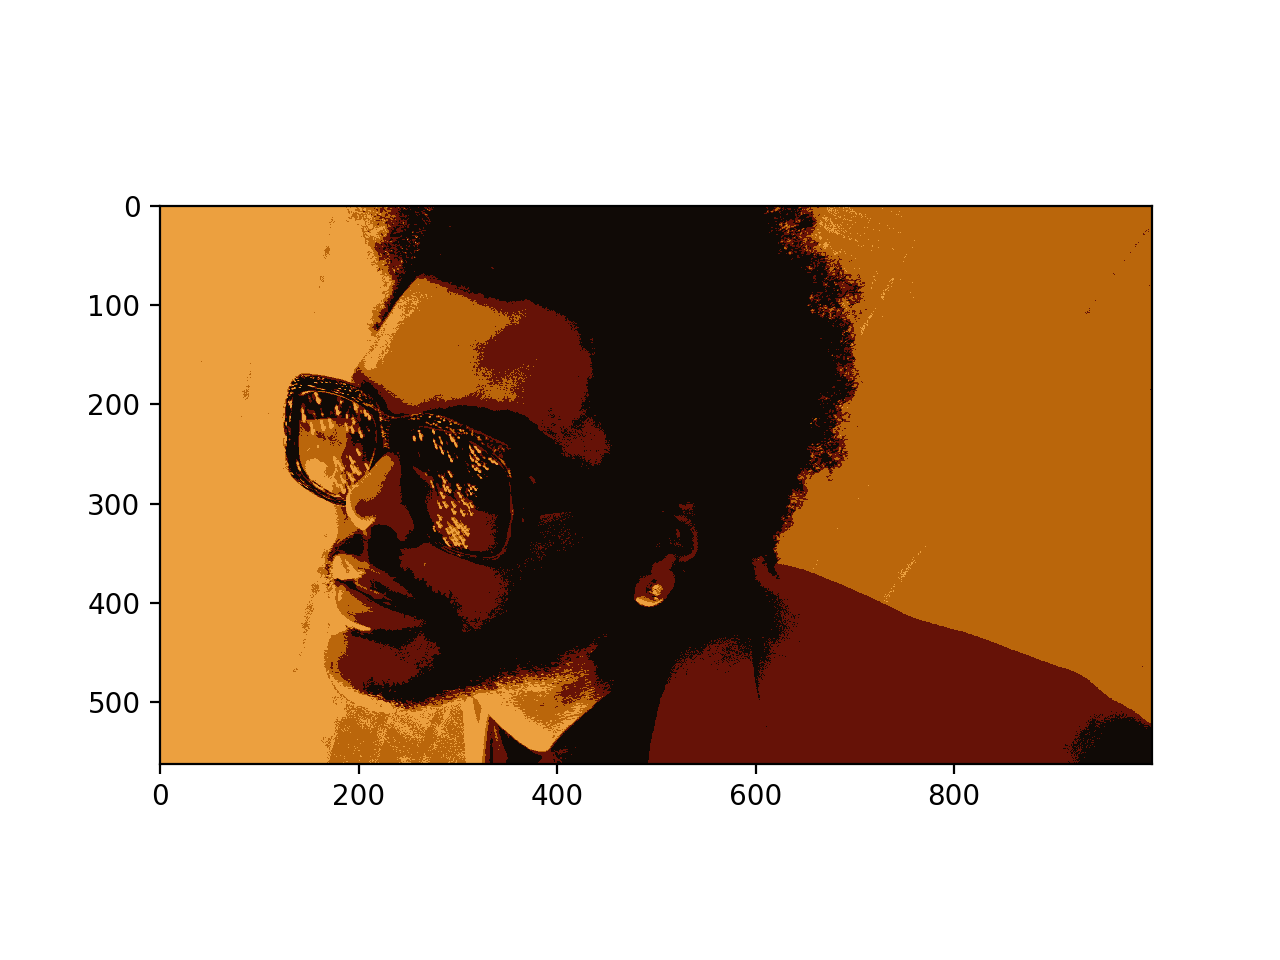

In [123]:
img_out = label2Img(labels, input_img)
plt.figure()
plt.imshow(cv2.cvtColor(img_out, cv2.COLOR_BGR2RGB))
plt.show()

In [125]:
filename = "skout.jpg"
# BGR_out = cv2.cvtColor(img_out, cv2.COLOR_Lab2BGR)
cv2.imwrite(filename, img_out);